In [1]:
# mount to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import os
import json
import bz2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
# read the male_word_file and female_word_file as word lists
path_male = '/content/drive/MyDrive/nytimes/male_word_file.txt'
path_female = '/content/drive/MyDrive/nytimes/female_word_file.txt'
male_word = []
female_word = []
with open(path_male, 'r') as f:
  for line in f.readlines():
    male_word.append(line.strip())

with open(path_female, 'r') as f:
  for line in f.readlines():
    female_word.append(line.strip())

# remove the possible redundant words
male_word = set(male_word)
female_word = set(female_word)

In [4]:
# find the gender-propelled words in quotations
def count_gender_word(path):
  df = pd.read_csv(path)
  lines = df.shape[0]
  df[['male_word_num','female_word_num','male_words','female_words','year_month']]=[0,0,None,None,None]
  for line in range(lines):
    quotation = df.at[line,'quotation']
    date = re.findall('\d\d\d\d-\d\d',df.at[line,'date'])[0]
    tokens = nltk.word_tokenize(quotation)
    male_num, female_num = 0, 0
    male_words, female_words = [], []
    for word in tokens:
      if word in male_word:
        male_num = male_num + 1
        male_words.append(word)
      if word in female_word:
        female_num = female_num + 1
        female_words.append(word)
    df.at[line,['male_word_num','female_word_num','male_words','female_words','year_month']]=[male_num,female_num,male_words,female_words,date]
  return df

In [5]:
# Data preprocessing
## read data of 2015 New York Times and count the gender-propelled word used
path_2015 = '/content/drive/MyDrive/Quotes_with_people/nytime_2015_with_people.csv'
df_2015_new = count_gender_word(path_2015)

## for "Gender" with more than one assignment, the first one is selected. 
from ast import literal_eval
def first_gender(gender):
  if gender == 'None':
    ans = None
  else: 
    ans = literal_eval(gender)[0][0]
  return ans
## Construct a new column "first_speaker_gender" for the selected first "Gender"
df_2015_new['first_speaker_gender'] = None
for i in range(df_2015_new.shape[0]):
  df_2015_new.at[i,'first_speaker_gender'] = first_gender(df_2015_new.at[i,'Gender'])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [6]:
df_2015_new.head(1)

,index_label,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,category,Gender,Nationality,Occupation,Party,male_word_num,female_word_num,male_words,female_words,year_month,first_speaker_gender
0,0,2015-02-27-014158,drilling a hole in the windshield,Alex Stamos,['Q50822408'],2015-02-27 19:58:47,10,"[['Alex Stamos', '0.6337'], ['None', '0.2113']...",['http://www.nextgov.com/cybersecurity/2015/02...,E,technology,[['male']],[['No data']],"[['businessperson', 'computer scientist']]",[['No data']],0,0,[],[],2015-02,male


In [24]:
def data_visualization(dataframe_processed):
  # Part1: analyze the male/female words as time changes
  df_male = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('year_month').sum()['male_word_num']
  df_female = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('year_month').sum()['female_word_num']
  df_ratio = df_male/df_female
  fig = plt.figure(figsize=(10,6))

  ## figure1-1 male/female counts change 
  plt.subplot(2,1,1)
  plt.xlabel('time')
  plt.ylabel('number of words')
  plt.plot(df_male,label="male")
  plt.plot(df_female,label="female")
  plt.legend(loc='best')
  plt.xticks(rotation=20)
  plt.title('How does masculine words/feminine words counts change as time goes?',fontsize=11)

  ## figure1-2 ratio change
  plt.subplot(2,1,2)
  plt.xlabel('time')
  plt.ylabel('male/female words')
  plt.xticks(rotation=20)
  plt.plot(df_ratio)
  plt.title('How about the ratio?',fontsize=11)
  plt.tight_layout()

  ## Part2: find out the constitution of masculine and feminine words in different categories
  df2_1 = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('category').sum()['male_word_num']
  df2_2 = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('category').sum()['female_word_num']
  df2 = pd.concat([df2_1, df2_2],axis=1).fillna(0)

  ## figure2-1 masculine/feminine words counted in different categories
  plt.figure(figsize=(10,6))
  plt.subplot(1,2,1)
  x_21 = range(df2.shape[0])
  y_21 = [i+0.4 for i in x_21]
  ticks_21 = [i+0.2 for i in x_21]
  label_list = df2.T.columns
  plt.bar(x_21, height = df2['male_word_num'], width=0.4, alpha=0.8, label='male')
  plt.bar(y_21, height = df2['female_word_num'], width=0.4, alpha=0.8, label='female')
  plt.xticks(ticks_21, label_list, rotation=90)
  plt.title('In different categories,\n how are the masculine and feminine words used?',fontsize=11)
  plt.legend() 

  ## figure2-2 In different categories, which type of words is preferred: masculine or feminine
  plt.subplot(1,2,2)
  bottom_y = df2['male_word_num']/(df2['female_word_num']+df2['male_word_num'])
  plt.ylim((-0.3,1.1))
  plt.bar(x_21,height=bottom_y, width=0.6, alpha=0.8, label='masculine words')
  plt.bar(x_21, height=1-bottom_y ,width=0.6, alpha=0.8, bottom=bottom_y, label='feminine words')
  plt.ylabel('percentage')
  plt.xlabel('category')
  plt.xticks(x_21, label_list, rotation=90)
  plt.legend()
  plt.title('In different categories,\nwhich type of words is preferred: masculine or feminine?',fontsize=11)
  plt.tight_layout()

  # Part3: analyze the gender of speakers

  ## figure3-1 Who contributes to the use of masculine words and is there any preference?
  df3 = dataframe_processed.groupby('first_speaker_gender').sum()[['male_word_num','female_word_num']].sort_values(by='male_word_num',ascending=False)
  label1 = ['male','female','others']
  label2 = ['masculine','feminine']
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.pie([df3['male_word_num']['male'],df3['male_word_num']['female'],df3['male_word_num'][2:].sum()],labels= label1, wedgeprops={'alpha':0.7}, autopct="%.1f%%")
  plt.title('Who contributes to the use of masculine words?',fontsize=11)
  plt.subplot(2,2,2)
  plt.pie([df3['female_word_num']['male'],df3['female_word_num']['female'],df3['female_word_num'][2:].sum()],labels= label1,wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Who contributes to the use of feminine words?',fontsize=11)
  plt.subplot(2,2,3)
  plt.pie([df3['male_word_num']['male'],df3['female_word_num']['male']],labels= label2, wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Males prefer to use:',fontsize=11)
  plt.subplot(2,2,4)
  plt.pie([df3['male_word_num']['female'],df3['female_word_num']['female']],labels= label2, wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Females prefer to use:',fontsize=11)
  plt.tight_layout()

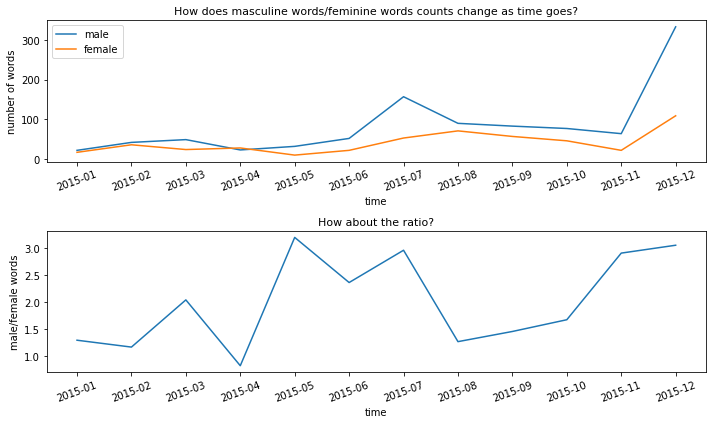

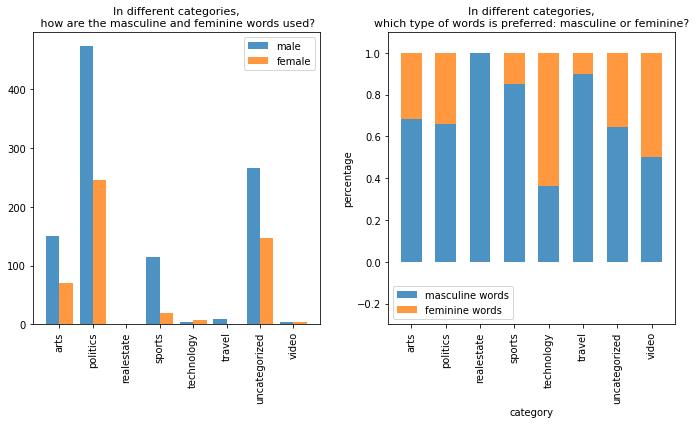

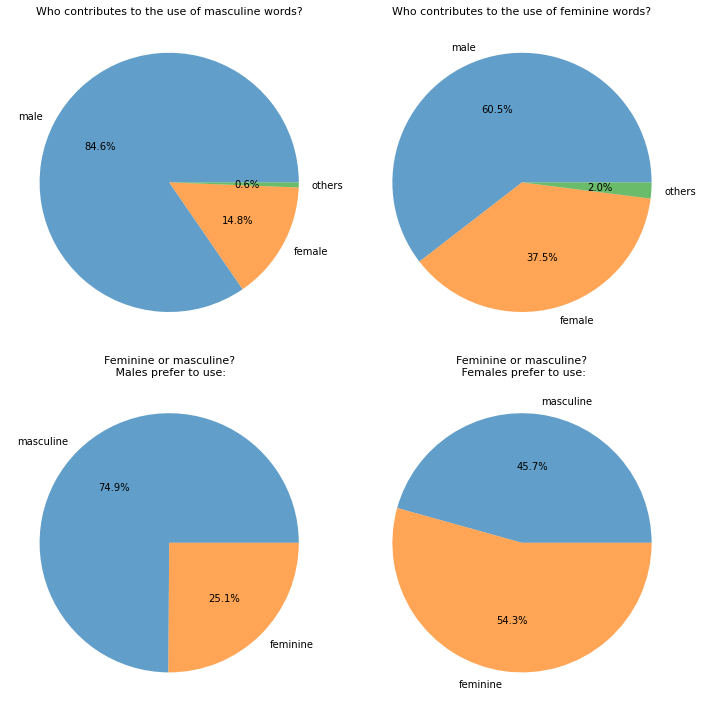

In [25]:
data_visualization(df_2015_new)

In [26]:
# Data preprocessing for data of 2016
## read data of 2016 New York Times that we've already counted the gender-propelled word used.
path_2016 = '/content/drive/MyDrive/Quotes_with_people/2016_with_people_with_words.csv'
df_2016_new = pd.read_csv(path_2016)

## for "Gender" with more than one assignment, the first one is selected. 
from ast import literal_eval
def first_gender(gender):
  if gender == 'None':
    ans = None
  else: 
    ans = literal_eval(gender)[0][0]
  return ans
## Construct a new column "first_speaker_gender" for the selected first "Gender"
df_2016_new['first_speaker_gender'] = None
for i in range(df_2016_new.shape[0]):
  df_2016_new.at[i,'first_speaker_gender'] = first_gender(df_2016_new.at[i,'Gender'])

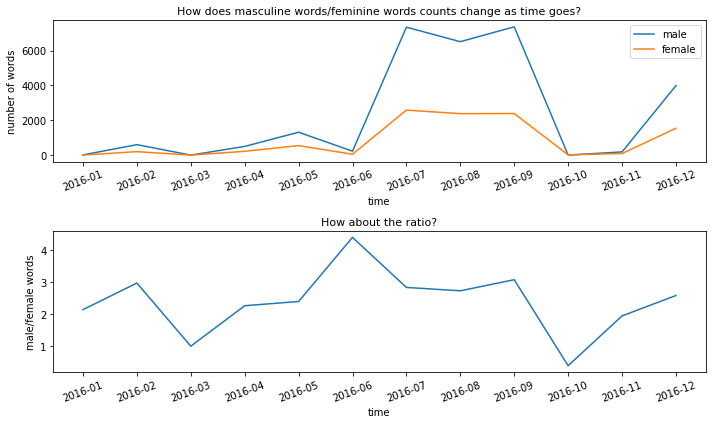

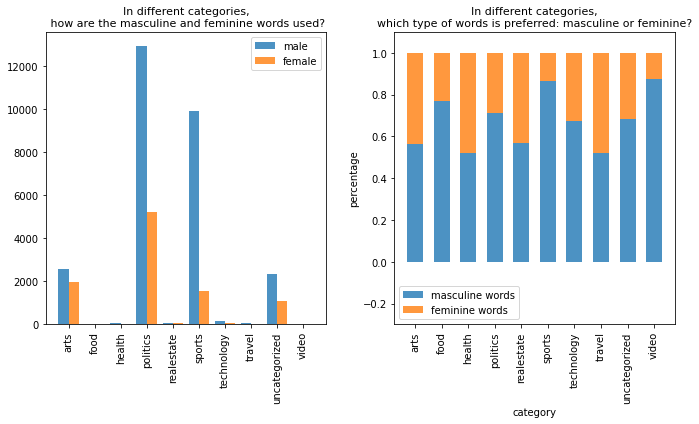

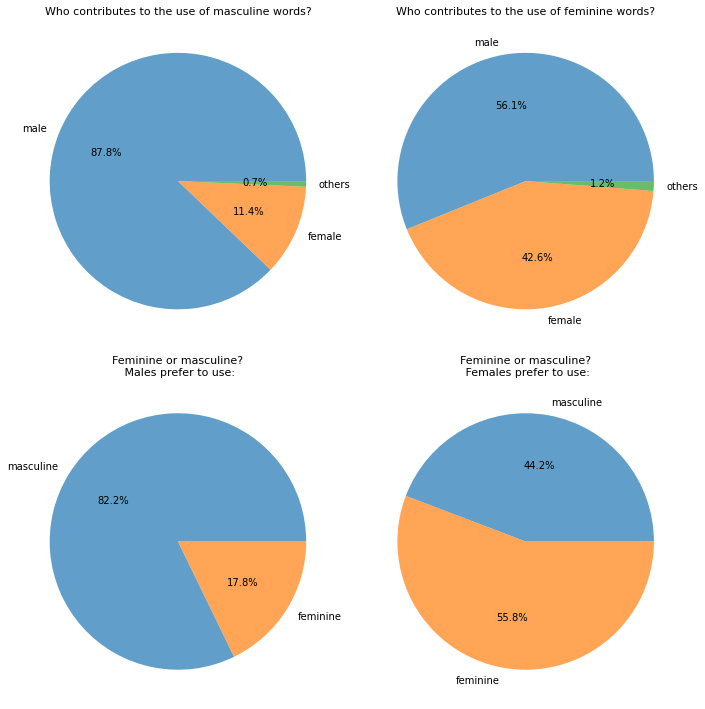

In [27]:
data_visualization(df_2016_new)